In [1]:
import pandas as pd
import numpy as np
import faiss
import networkx as nx
import matplotlib.pyplot as plt
import os

# Load and Create Graphs

## Load data

In [2]:
input_folder = "./embeddings/romi_embeddings/"
output_folder = "./grpahs/alligment_graphs/"

In [3]:
# k = the number of nearest neightboors. 
def create_graphs_from_embeddings(file_path, threshold):
    # Load the CSV file
    df = pd.read_csv(file_path)
    # Extract TCR sequences and embeddings
    tcr_sequences = df.iloc[:, 0].values
    embeddings = df.iloc[:, 1:].values.astype('float32')

    # Normalize the embeddings
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]

    # Function to create FAISS index and search for nearest neighbors
    def create_faiss_index(embeddings, k):
        index = faiss.IndexFlatIP(embeddings.shape[1])  # Using inner product for cosine similarity
        index.add(embeddings)
        distances, indices = index.search(embeddings, k)
        return distances, indices

    # Function to create the adjacency matrix
    def create_adjacency_matrix(num_embeddings, indices, distances, k):
        adjacency_matrix = np.zeros((num_embeddings, num_embeddings))
        for i in range(num_embeddings):
            for j in range(1, k):  # Skip the first neighbor (itself)
                adjacency_matrix[i, indices[i, j]] = distances[i, j]
        return adjacency_matrix

   # Function to evaluate metrics
    def evaluate_metrics(adjacency_matrix, threshold, node_names):
        G = nx.Graph()
        num_embeddings = adjacency_matrix.shape[0]
        for i in range(num_embeddings):
            for j in range(i + 1, num_embeddings):
                if adjacency_matrix[i, j] > threshold:
                    G.add_edge(node_names[i], node_names[j], weight=adjacency_matrix[i, j])
        return G

    # Create FAISS index and search for nearest neighbors
    k = int(np.sqrt(embeddings.shape[0]))
    distances, indices = create_faiss_index(embeddings, k)
    # Create the adjacency matrix
    adjacency_matrix = create_adjacency_matrix(embeddings.shape[0], indices, distances, k)
    G = evaluate_metrics(adjacency_matrix, threshold, tcr_sequences)
    return G

In [4]:
from networkx.algorithms.cluster import average_clustering
from networkx.algorithms.components import number_connected_components
import matplotlib.cm as cm

In [18]:
def evaluating_thresholds(file_path):
    df = pd.read_csv(file_path)
    # Extract TCR sequences and embeddings
    tcr_sequences = df.iloc[:, 0].values
    embeddings = df.iloc[:, 1:].values.astype('float32')

    # Normalize the embeddings
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]

    # Function to create FAISS index and search for nearest neighbors
    def create_faiss_index(embeddings, k):
        index = faiss.IndexFlatIP(embeddings.shape[1])  # Using inner product for cosine similarity
        index.add(embeddings)
        distances, indices = index.search(embeddings, k)
        return distances, indices

    # Function to create the adjacency matrix
    def create_adjacency_matrix(num_embeddings, indices, distances, k):
        adjacency_matrix = np.zeros((num_embeddings, num_embeddings))
        for i in range(num_embeddings):
            for j in range(1, k):  # Skip the first neighbor (itself)
                adjacency_matrix[i, indices[i, j]] = distances[i, j]
        return adjacency_matrix

    # Function to evaluate metrics
    def evaluate_metrics(adjacency_matrix, threshold):
        G = nx.Graph()
        num_embeddings = adjacency_matrix.shape[0]
        for i in range(num_embeddings):
            for j in range(i + 1, num_embeddings):
                if adjacency_matrix[i, j] > threshold:
                    G.add_edge(i, j, weight=adjacency_matrix[i, j])
        clustering_coefficient = average_clustering(G)
        num_components = number_connected_components(G)
        return clustering_coefficient, num_components, G

    # Define different k values and thresholds to explore
    N = embeddings.shape[0]
    k_values = [5, 10, 15, 20, int(np.sqrt(N)), int(np.log(N)) + 1]
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]  # Example thresholds between 0.5 and 0.9

    # Iterate over different k values and thresholds
    results = []
    graphs = {}  # Dictionary to store graphs
    adjacency_matrices = []  # List to store adjacency matrices

    for k in k_values:
        distances, indices = create_faiss_index(embeddings, k)
        adjacency_matrix = create_adjacency_matrix(embeddings.shape[0], indices, distances, k)
        adjacency_matrices.append((k, adjacency_matrix))  # Store the adjacency matrix with its k value
        for threshold in thresholds:
            cc, nc, G = evaluate_metrics(adjacency_matrix, threshold)
            results.append((k, threshold, cc, nc))
            graphs[(k, threshold)] = G  # Store the graph with (k, threshold) as key

    # Convert results to DataFrame for better visualization
    results_df = pd.DataFrame(results, columns=['k', 'threshold', 'clustering_coefficient', 'num_components'])
    
    # print(results_df)

    # # Plot the results
    # fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # # Plot clustering coefficient
    # for k in k_values:
    #     subset = results_df[results_df['k'] == k]
    #     axes[0].plot(subset['threshold'], subset['clustering_coefficient'], label=f'k={k}')
    # axes[0].set_xlabel('Threshold')
    # axes[0].set_ylabel('Clustering Coefficient')
    # axes[0].legend()
    # axes[0].set_title('Clustering Coefficient vs Threshold for Different k Values')

    # # Plot number of components
    # for k in k_values:
    #     subset = results_df[results_df['k'] == k]
    #     axes[1].plot(subset['threshold'], subset['num_components'], label=f'k={k}')
    # axes[1].set_xlabel('Threshold')
    # axes[1].set_ylabel('Number of Components')
    # axes[1].legend()
    # axes[1].set_title('Number of Components vs Threshold for Different k Values')

    # plt.tight_layout()
    # plt.show()

  
    # # Plot histogram of distances and percentiles for each k value
    # fig, ax = plt.subplots(figsize=(12, 8))
    # colors = cm.rainbow(np.linspace(0, 1, len(adjacency_matrices)))

    # # Combine all distances for histogram
    # all_distances_flat = np.concatenate([adjacency_matrix.flatten() for _, adjacency_matrix in adjacency_matrices])
    # all_distances_flat = all_distances_flat[all_distances_flat > 0]

    # # Plot histogram
    # ax.hist(all_distances_flat, bins=50, alpha=0.75, label='All Distances')
    # ax.set_title('Histogram of Distances')
    # ax.set_xlabel('Cosine Similarity Distance')
    # ax.set_ylabel('Frequency (Pairs Count)')
    
    # Determine the number of subplots needed
    num_plots = len(adjacency_matrices)
    cols = 2  # Number of columns for subplots
    rows = (num_plots + cols - 1) // cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    # Flatten axes array for easy iteration if there are multiple rows
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    colors = cm.rainbow(np.linspace(0, 1, num_plots))

    all_percentiles = []
    for (k, adjacency_matrix), color, ax in zip(adjacency_matrices, colors, axes):
        distances_flat = adjacency_matrix.flatten()
        distances_flat = distances_flat[distances_flat > 0]
        
        ax.hist(distances_flat, bins=50, alpha=0.75, color=color, label=f'k={k}')
        ax.set_title(f'Histogram of Distances for k={k}')
        ax.set_xlabel('Cosine Similarity Distance')
        ax.set_ylabel('Frequency (Pairs Count)')
        ax.legend()

        percentiles = np.percentile(distances_flat, [25, 50, 75, 90, 95, 99])
        all_percentiles.append(percentiles)
        # Print the percentiles for each k value
        print(f"Percentiles of Distances for k={k}: {percentiles}")
    
    # Calculate and print average percentiles
    avg_percentiles = np.mean(all_percentiles, axis=0)
    print(f"Average Percentiles of Distances: {avg_percentiles}")

    # Remove empty subplots if the number of k values is less than the grid size
    for ax in axes[num_plots:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

    # # Plot percentiles
    # for (k, adjacency_matrix), color in zip(adjacency_matrices, colors):
    #     distances_flat = adjacency_matrix.flatten()
    #     distances_flat = distances_flat[distances_flat > 0]
    #     ax.hist(distances_flat, bins=50, alpha=0.5, color=color, label=f'k={k}')

    #     percentiles = np.percentile(distances_flat, [25, 50, 75, 90, 95, 99])
    #     all_percentiles.append(percentiles)
    #     # Print the percentiles for each k value
    #     print(f"Percentiles of Distances for k={k}: {percentiles}")
    
    # # Calculate and print average percentiles
    # avg_percentiles = np.mean(all_percentiles, axis=0)
    # print(f"Average Percentiles of Distances: {avg_percentiles}")

    # ax.set_title('Histograms of Distances for Different k Values')
    # ax.set_xlabel('Cosine Similarity Distance')
    # ax.set_ylabel('Frequency (Pairs Count)')
    # ax.legend()

    # plt.show()


Percentiles of Distances for k=5: [0.80662104 0.85124752 0.91265488 0.94340336 0.95678347 0.97475704]
Percentiles of Distances for k=10: [0.79074055 0.83383331 0.89857468 0.93180197 0.94613481 0.96781945]
Percentiles of Distances for k=15: [0.7810728  0.8237251  0.89005135 0.9248001  0.93932317 0.96296633]
Percentiles of Distances for k=20: [0.77396296 0.81663528 0.88377255 0.9196119  0.93461338 0.95908701]
Percentiles of Distances for k=123: [0.71524954 0.7560932  0.8201932  0.8716473  0.89496464 0.93080622]
Percentiles of Distances for k=10: [0.79074055 0.83383331 0.89857468 0.93180197 0.94613481 0.96781945]
Average Percentiles of Distances: [0.77639791 0.81922795 0.88397022 0.9205111  0.93632571 0.96054259]


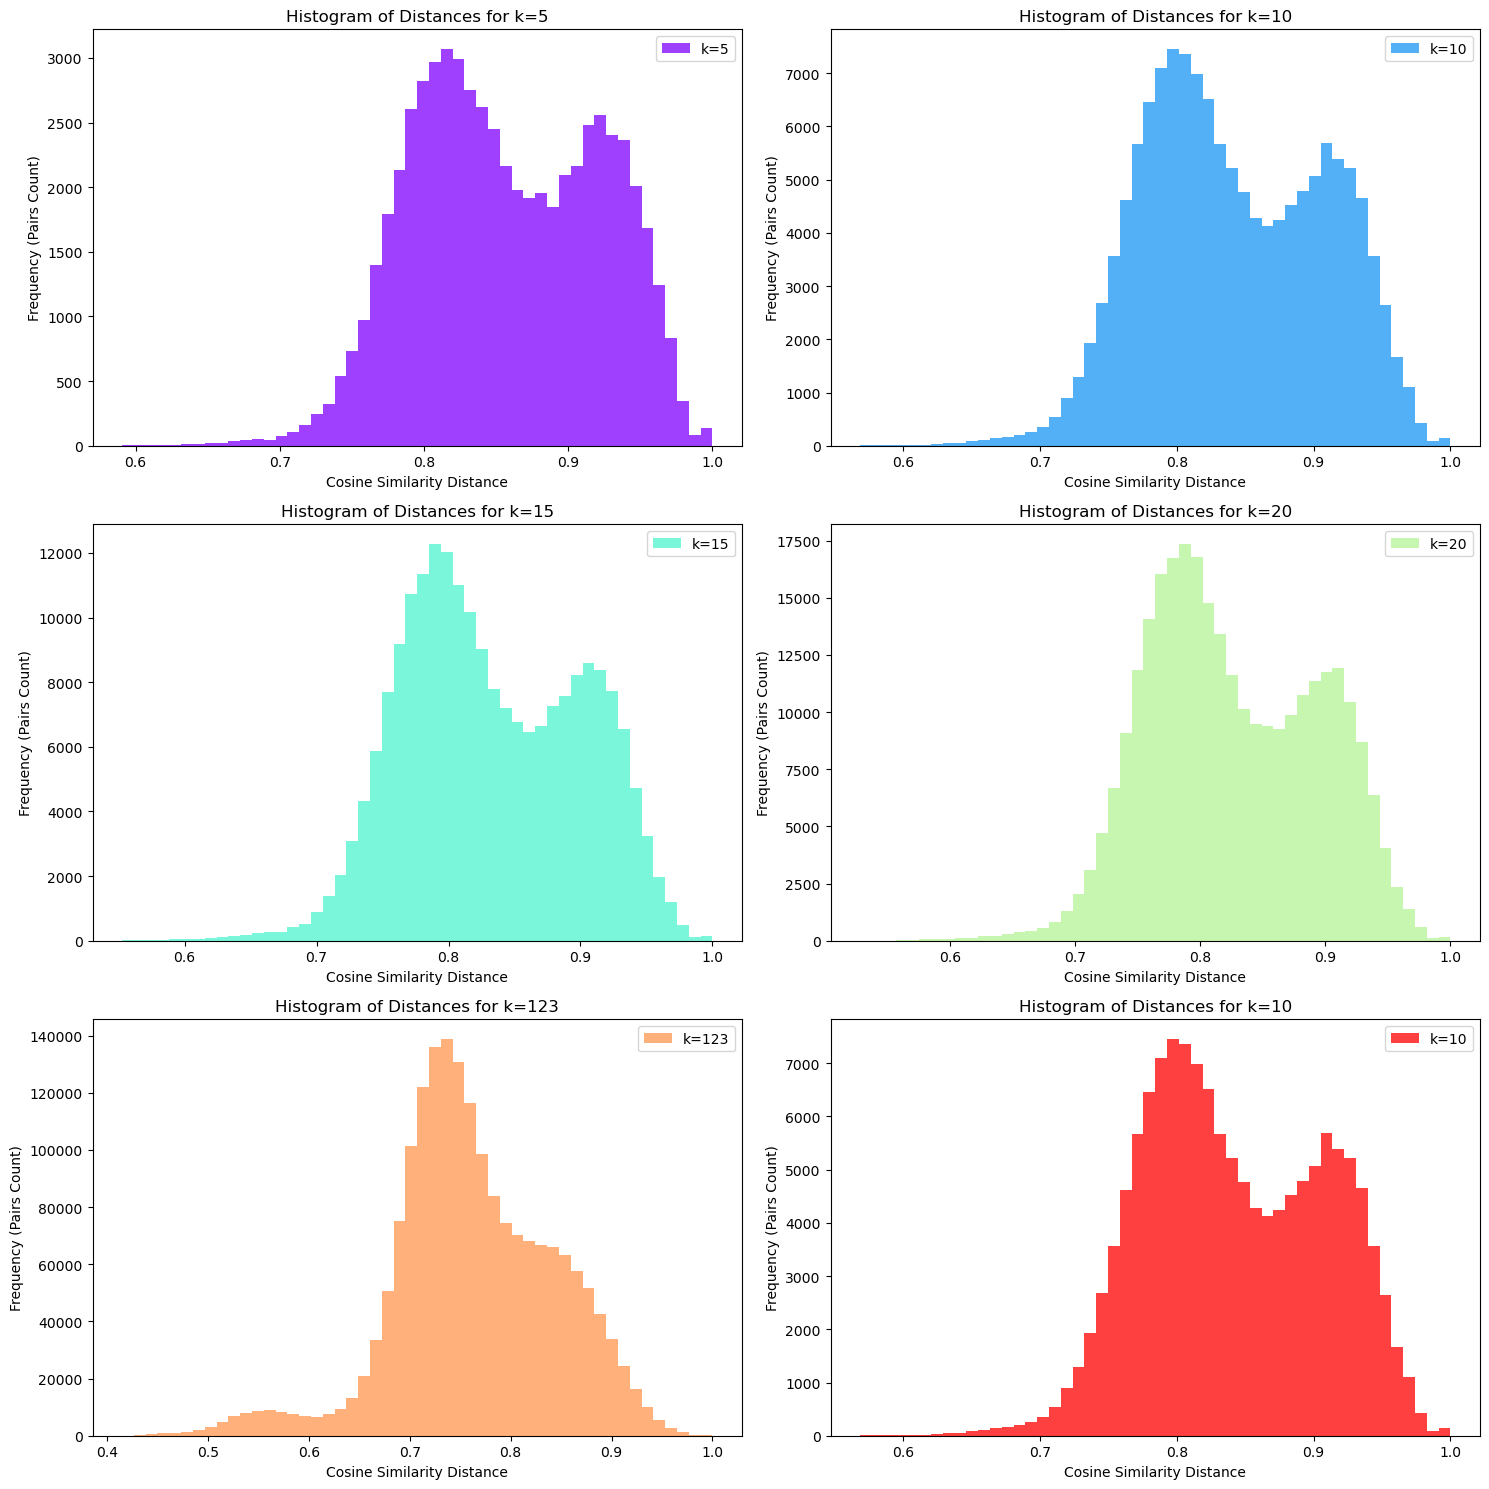

In [19]:
evaluating_thresholds("./embeddings/romi_embeddings/32_H.csv")

Percentiles of Distances for k=5: [0.81268263 0.84281999 0.87972878 0.91946911 0.9375844  0.96263926]
Percentiles of Distances for k=10: [0.79774271 0.82785013 0.86322153 0.90699093 0.92620819 0.95460712]
Percentiles of Distances for k=15: [0.78881149 0.8187798  0.85415065 0.89882243 0.91957053 0.94898781]
Percentiles of Distances for k=20: [0.78226656 0.81231922 0.84756774 0.8927689  0.91447956 0.94494611]
Percentiles of Distances for k=149: [0.72556436 0.75769895 0.79144913 0.83251522 0.86201048 0.90970016]
Percentiles of Distances for k=11: [0.79566891 0.82574689 0.86105436 0.90516847 0.92466062 0.95312329]
Average Percentiles of Distances: [0.78378944 0.8142025  0.8495287  0.89262251 0.91408563 0.94566729]


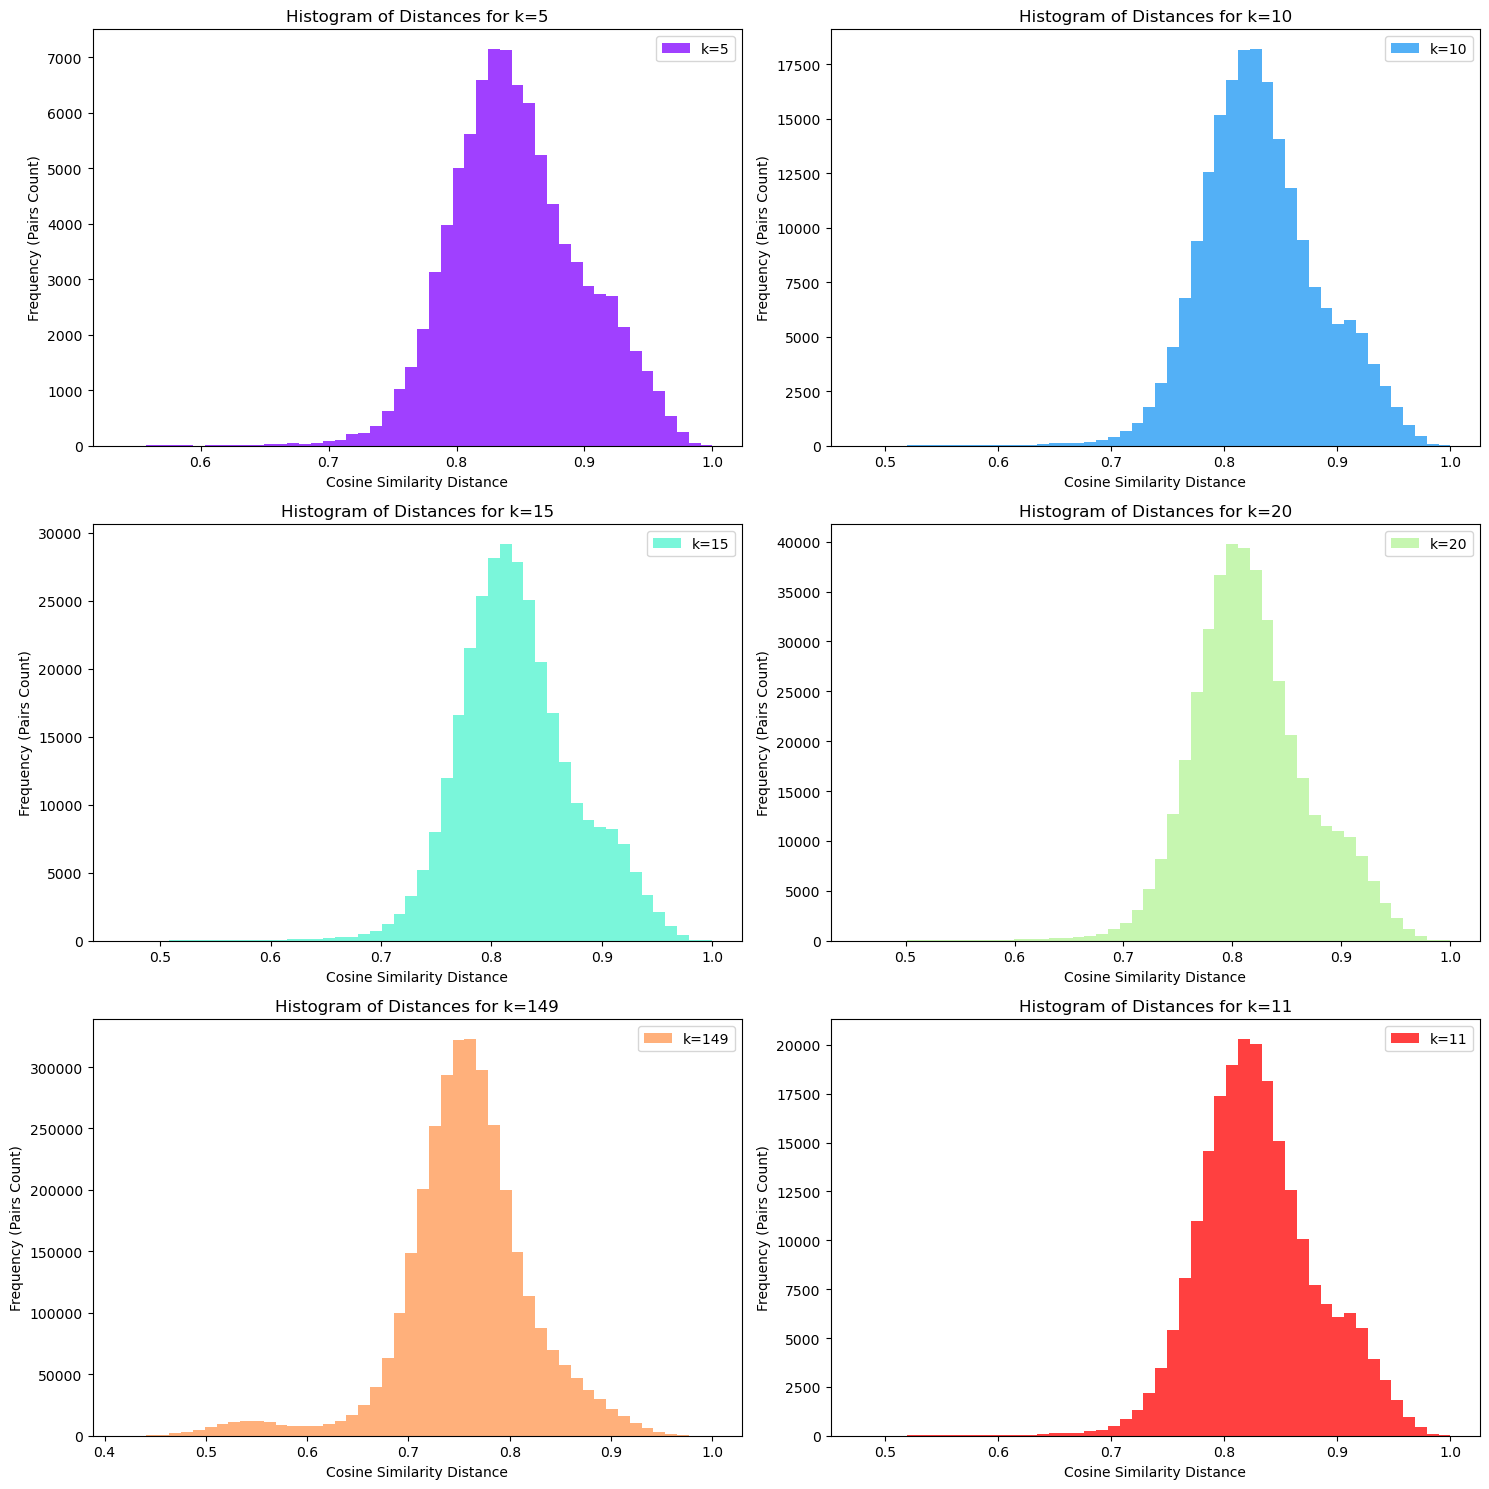

In [17]:
evaluating_thresholds("./embeddings/romi_embeddings/26_OC.csv")

In [10]:
graphs = {}
threshold = 0.9

In [11]:
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(input_folder, file_name)
        # trimming .csv from file_name
        graphs[file_name.split(".")[0]] = create_graphs_from_embeddings(file_path, threshold)
        

KeyboardInterrupt: 